In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

import tensorflow as tf

import gpflow
from gpflow.models import SVGP
from gpflow.utilities import read_values, multiple_assign, set_trainable

import invgp
from invgp.models.sample_SVGP import sample_SVGP
from invgp_experiments import utils

In [2]:
np.random.seed(0)

__Generate 200 datapoints__

In [3]:
X = np.vstack((np.random.uniform(0, 6, 50)[:, None], 8))
Y = np.sin(2 * X) + 0.1 * np.cos(7 * X) + np.random.randn(*X.shape) * 0.4
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
train_dataset = train_dataset.shuffle(1024).batch(len(X))
train_iter = iter(train_dataset.repeat())

__Initialize SVGP models__

In [4]:
SVGP_model, sample_SVGP_model, matheron_sample_SVGP_model = [
    m(
        gpflow.kernels.SquaredExponential(),
        gpflow.likelihoods.Gaussian(),
        inducing_variable=X.copy(),
        num_data=len(X),
        **kw,
    )
    for m, kw in [(SVGP, {}), (sample_SVGP, {"matheron_sampler": False}), (sample_SVGP, {"matheron_sampler": True})]
]

In [5]:
print('Untrained model elbos are:')
for n, m in [("SVGP", SVGP_model), ("sample_SVGP", sample_SVGP_model), ("Matheron sample_SVGP", matheron_sample_SVGP_model)]:
    elbos = [m.elbo((X, Y)).numpy() for _ in range(300)]
    print(f"{n: <20}: {np.mean(elbos):.5f} ({np.std(elbos):.2f} stddev)")

Untrained model elbos are:
SVGP                : -92.63127 (0.00 stddev)
sample_SVGP         : -92.29249 (10.42 stddev)
Matheron sample_SVGP: -92.79516 (10.20 stddev)


__Define and run the optimiziation loop for SVGP model__

In [6]:
training_loss = SVGP_model.training_loss_closure(train_iter, compile=True)
optimizer = tf.keras.optimizers.Adam(0.01)
set_trainable(SVGP_model.inducing_variable, False)
@tf.function
def optimization_step():
    optimizer.minimize(training_loss, SVGP_model.trainable_variables)
elbo_hist = []
for step in range(500):
    optimization_step()
    if step % 1 == 0:
        minibatch_elbo = -training_loss().numpy()
        print('Step: %s, Mini batch elbo: %s' % (step, minibatch_elbo))
        elbo_hist.append(minibatch_elbo)

Step: 0, Mini batch elbo: -90.95871116616806
Step: 1, Mini batch elbo: -89.32196600700874
Step: 2, Mini batch elbo: -87.84466978870178
Step: 3, Mini batch elbo: -86.47613162433964
Step: 4, Mini batch elbo: -85.17918276424273
Step: 5, Mini batch elbo: -83.96496045659023
Step: 6, Mini batch elbo: -82.84363840226486
Step: 7, Mini batch elbo: -81.80906408949662
Step: 8, Mini batch elbo: -80.8435845402368
Step: 9, Mini batch elbo: -79.93493374216627
Step: 10, Mini batch elbo: -79.0816548877533
Step: 11, Mini batch elbo: -78.28554950520524
Step: 12, Mini batch elbo: -77.5447178036076
Step: 13, Mini batch elbo: -76.85230423666125
Step: 14, Mini batch elbo: -76.20056811559219
Step: 15, Mini batch elbo: -75.58509317595205
Step: 16, Mini batch elbo: -75.0045745223813
Step: 17, Mini batch elbo: -74.4578655630299
Step: 18, Mini batch elbo: -73.94192098702952
Step: 19, Mini batch elbo: -73.45213256755216
Step: 20, Mini batch elbo: -72.98432288278121
Step: 21, Mini batch elbo: -72.53621206607964
Ste

Step: 199, Mini batch elbo: -36.42202021981264
Step: 200, Mini batch elbo: -36.32114419558921
Step: 201, Mini batch elbo: -36.22150599224297
Step: 202, Mini batch elbo: -36.123103596153435
Step: 203, Mini batch elbo: -36.02594957430616
Step: 204, Mini batch elbo: -35.930052696782404
Step: 205, Mini batch elbo: -35.83538956149231
Step: 206, Mini batch elbo: -35.74198217135738
Step: 207, Mini batch elbo: -35.64981500281631
Step: 208, Mini batch elbo: -35.558894823325474
Step: 209, Mini batch elbo: -35.46922128820759
Step: 210, Mini batch elbo: -35.38078218560847
Step: 211, Mini batch elbo: -35.29359652333066
Step: 212, Mini batch elbo: -35.20763726561623
Step: 213, Mini batch elbo: -35.12292338287335
Step: 214, Mini batch elbo: -35.03944119630243
Step: 215, Mini batch elbo: -34.95718934188541
Step: 216, Mini batch elbo: -34.87616806884439
Step: 217, Mini batch elbo: -34.79637033308095
Step: 218, Mini batch elbo: -34.71779649586275
Step: 219, Mini batch elbo: -34.64043564598513
Step: 220,

Step: 400, Mini batch elbo: -31.268678801220286
Step: 401, Mini batch elbo: -31.26789282971668
Step: 402, Mini batch elbo: -31.26712102364052
Step: 403, Mini batch elbo: -31.2663642654255
Step: 404, Mini batch elbo: -31.265623599582668
Step: 405, Mini batch elbo: -31.26490174281578
Step: 406, Mini batch elbo: -31.264205513950273
Step: 407, Mini batch elbo: -31.263547550624267
Step: 408, Mini batch elbo: -31.262950614923597
Step: 409, Mini batch elbo: -31.262440765994413
Step: 410, Mini batch elbo: -31.26203411163159
Step: 411, Mini batch elbo: -31.261640459918944
Step: 412, Mini batch elbo: -31.261092248738
Step: 413, Mini batch elbo: -31.260197511509872
Step: 414, Mini batch elbo: -31.259154793693114
Step: 415, Mini batch elbo: -31.25832800747854
Step: 416, Mini batch elbo: -31.257856031397097
Step: 417, Mini batch elbo: -31.257441141806233
Step: 418, Mini batch elbo: -31.25675176893911
Step: 419, Mini batch elbo: -31.255924544235214
Step: 420, Mini batch elbo: -31.25530204567233
Step

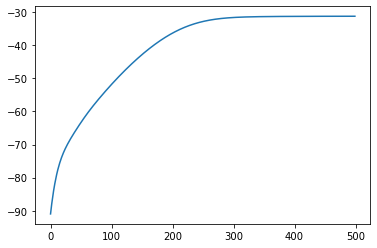

In [7]:
plt.plot(elbo_hist)

__Initialize sample SVGP models with fitted parameters from "regular" SVGP__

In [8]:
trained_params = read_values(SVGP_model)
multiple_assign(sample_SVGP_model, trained_params)
multiple_assign(matheron_sample_SVGP_model, trained_params)

__Visualize data and fitted model__

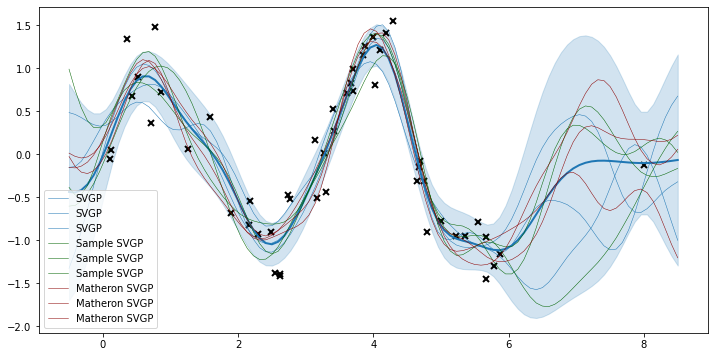

In [9]:
# test points
xx = np.linspace(-0.5, 8.5, 100).reshape(100, 1)
# predict mean and variance of latent GP at test points
mean, var = SVGP_model.predict_f(xx)
# generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
SVGP_samples = SVGP_model.predict_f_samples(xx, 3)  
sample_SVGP_samples = sample_SVGP_model.predict_f_samples(xx, 3)  
matheron_SVGP_samples = matheron_sample_SVGP_model.predict_f_samples(xx, 3)

# plot
plt.figure(figsize=(12, 6))
plt.plot(X, Y, "kx", mew=2)
plt.plot(xx, mean, "C0", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,)
plt.plot(xx, SVGP_samples[:, :, 0].numpy().T, "C0", linewidth=0.5, label='SVGP')
plt.plot(xx, sample_SVGP_samples[:, :, 0].numpy().T, "C0", linewidth=0.5, c='darkgreen', label='Sample SVGP')
plt.plot(xx, matheron_SVGP_samples[:, :, 0].numpy().T, "C0", linewidth=0.5, c='darkred', label='Matheron SVGP')
plt.legend()
# _ = plt.xlim(-0.1, 6.1)
plt.show()

In [10]:
print('Trained model elbos are:')
for n, m in [("SVGP", SVGP_model), ("sample_SVGP", sample_SVGP_model), ("Matheron sample_SVGP", matheron_sample_SVGP_model)]:
    elbos = [m.elbo((X, Y)).numpy() for _ in range(300)]
    print(f"{n: <20}: {np.mean(elbos):.5f} ({np.std(elbos):.2f} stddev)")

Trained model elbos are:
SVGP                : -31.23010 (0.00 stddev)
sample_SVGP         : -31.16378 (1.15 stddev)
Matheron sample_SVGP: -31.15436 (1.22 stddev)
